In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
apiKey = os.getenv("quandl_key")

In [3]:
amzn = quandl.get("WIKI/AMZN", start_date="2017-01-01", end_date="2018-01-01")

In [4]:
amzn.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-01-03,757.92,758.7595,747.7000,753.67,3521066.0,0.0,1.0,757.92,758.7595,747.7000,753.67,3521066.0
2017-01-04,758.39,759.6800,754.2000,757.18,2510526.0,0.0,1.0,758.39,759.6800,754.2000,757.18,2510526.0
2017-01-05,761.55,782.3999,760.2557,780.45,5830068.0,0.0,1.0,761.55,782.3999,760.2557,780.45,5830068.0
2017-01-06,782.36,799.4400,778.4800,795.99,5986234.0,0.0,1.0,782.36,799.4400,778.4800,795.99,5986234.0
2017-01-09,798.00,801.7742,791.7700,796.92,3446109.0,0.0,1.0,798.00,801.7742,791.7700,796.92,3446109.0


In [5]:

short_window = 30
long_window = 90
signals = pd.DataFrame(index=amzn.index)

In [6]:
signals['signal'] = 0.0
signals['short_mavg'] = amzn['Close'].rolling(window=short_window, 
                                              min_periods=1, 
                                              center=False).mean()
signals['long_mavg'] = amzn['Close'].rolling(window=long_window, 
                                             min_periods=1, 
                                             center=False).mean()

In [7]:
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0,0.0) 
signals['positions'] = signals['signal'].diff()

In [8]:
signals

,signal,short_mavg,long_mavg,positions
Date,,,,
2017-01-03,0.0,753.670000,753.670000,NaN
2017-01-04,0.0,755.425000,755.425000,0.0
2017-01-05,0.0,763.766667,763.766667,0.0
2017-01-06,0.0,771.822500,771.822500,0.0
2017-01-09,0.0,776.842000,776.842000,0.0
...,...,...,...,...
2017-12-22,1.0,1159.429000,1048.693444,0.0
2017-12-26,1.0,1161.142667,1050.899889,0.0
2017-12-27,1.0,1162.912333,1053.363111,0.0


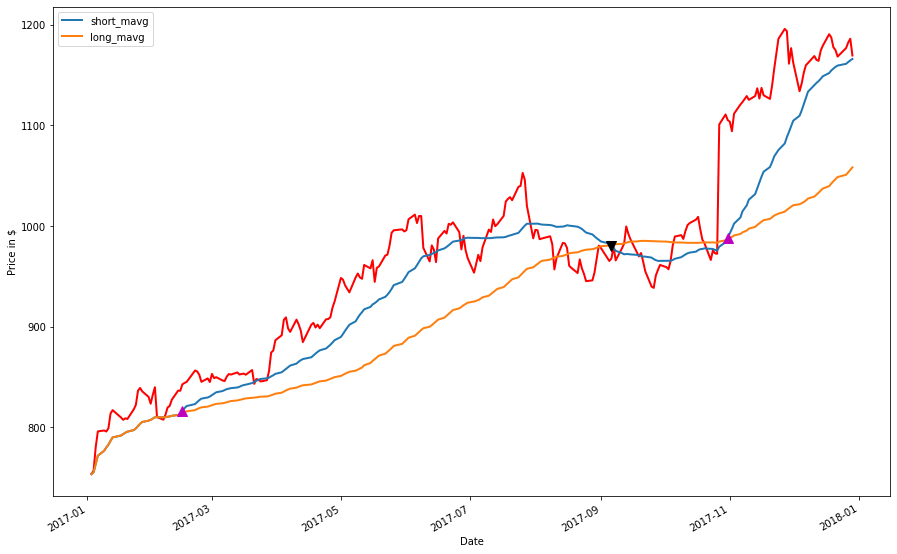

In [17]:
fig = plt.figure(figsize=(15,10))
ax1 =  fig.add_subplot(111, ylabel='Price in $')

amzn['Close'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

ax1.plot(signals.loc[signals.positions == 1.0].index,
        signals.short_mavg[signals.positions == 1.0],
        '^', markersize=10, color='m')

ax1.plot(signals.loc[signals.positions == -1.0].index,
        signals.short_mavg[signals.positions == -1.0],
        'v', markersize=10, color='k')

plt.show()


### Run trial trades with bot

In [22]:
initial_capital = float(50000)
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AMZN'] = 50* signals['signal']
portfolio = positions.multiply(amzn['Adj. Close'], axis=0)
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(amzn['Adj. Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(amzn['Adj. Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()


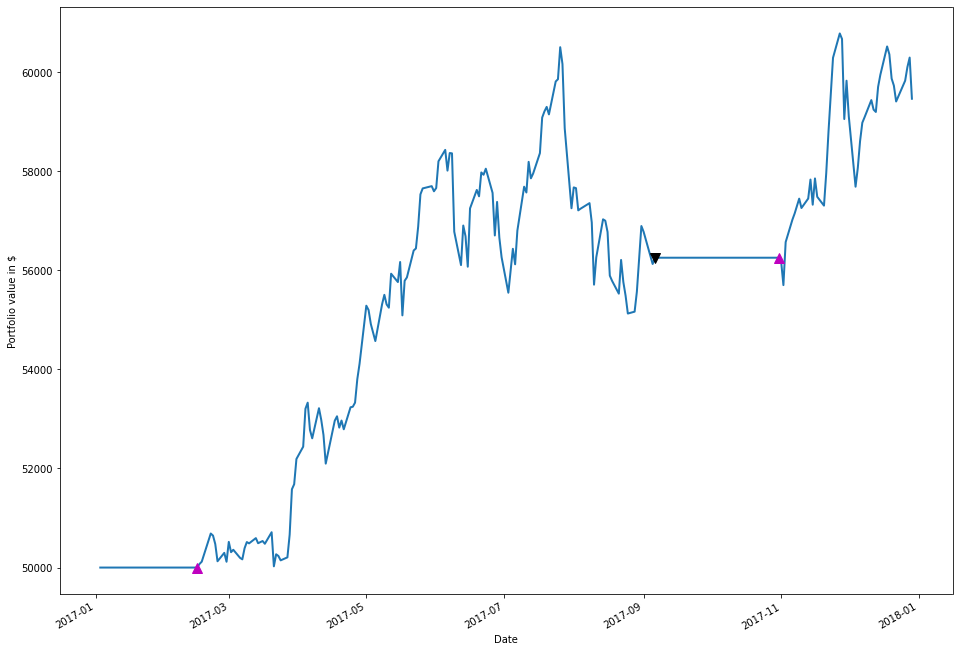

In [30]:
fig = plt.figure(figsize=(16,12))
ax1 =  fig.add_subplot(111, ylabel='Portfolio value in $')

portfolio['total'].plot(ax=ax1, lw=2.)
# signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index,
        portfolio.total[signals.positions == 1.0],
        '^', markersize=10, color='m')

ax1.plot(portfolio.loc[signals.positions == -1.0].index,
        portfolio.total[signals.positions == -1.0],
        'v', markersize=10, color='k')

plt.show()


In [31]:
returns = portfolio['returns']
np.sqrt(252) * (returns.mean()/returns.std())

1.4726162350367162